In [2]:
# compare SOTA algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from joblib import dump, load
from main import *
import warnings
warnings.filterwarnings("ignore")

keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
np.random.seed(0)

In [3]:
def get_metrics(y_test, y_pred):
    
    predictions = np.round(y_pred)
    
    AUC = round(roc_auc_score(y_test, y_pred),3)
    Accuracy = round(accuracy_score(y_test, predictions),3)
    Precision = round(precision_score(y_test, predictions),3)
    Recall = round(recall_score(y_test, predictions),3)
    F1_Score = round(f1_score(y_test, predictions),3)
    MCC = round(matthews_corrcoef(y_test, predictions),3)
    Kappa = round(cohen_kappa_score(y_test, predictions),3)
    
    return [AUC, Accuracy, Precision, Recall, F1_Score, MCC, Kappa]

In [4]:
def cross_validation(model, model_name, X, y):
    kf = KFold(n_splits=5)
    AUC=[]
    Accuracy=[]
    Precision=[]
    Recall=[]
    F1_Score=[]
    MCC=[]
    Kappa=[]
    
    tprs = []
    base_fpr = np.linspace(0, 1, 100)
    
    
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        this_model = model
        
        if "SMTRI" in model_name:
            this_model.fit(X_train, y_train, epochs=78, batch_size=32, verbose=0)
            y_pred = this_model.predict(X_test, verbose=0)
        else:
            this_model.fit(X_train, y_train)
            y_pred = this_model.predict(X_test)
            
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        
        metrics = get_metrics(y_test, y_pred)
        AUC.append(metrics[0])
        Accuracy.append(metrics[1])
        Precision.append(metrics[2])
        Recall.append(metrics[3])
        F1_Score.append(metrics[4])
        MCC.append(metrics[5])
        Kappa.append(metrics[6])
        
        
    print("\n***** "+model_name+" *****")
    print('AUC: '+f"{round(np.mean(AUC),3)}"+u"\u00B1"+f"{round(np.std(AUC),3)}")
    print('Accuracy: '+f"{round(np.mean(Accuracy),3)}"+u"\u00B1"+f"{round(np.std(Accuracy),3)}")
    print('Precision: '+f"{round(np.mean(Precision),3)}"+u"\u00B1"+f"{round(np.std(Precision),3)}")
    print('Recall: '+f"{round(np.mean(Recall),3)}"+u"\u00B1"+f"{round(np.std(Recall),3)}")
    print('F1-Score: '+f"{round(np.mean(F1_Score),3)}"+u"\u00B1"+f"{round(np.std(F1_Score),3)}")
    print('MCC: '+f"{round(np.mean(MCC),3)}"+u"\u00B1"+f"{round(np.std(MCC),3)}")
    print('Kappa: '+f"{round(np.mean(Kappa),3)}"+u"\u00B1"+f"{round(np.std(Kappa),3)}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    
    return mean_tpr

In [5]:
# load three testing datasets
testing_set_1 = pd.read_csv('./data/PDB_testing_set.csv')
x_1 = np.array(testing_set_1.iloc[:,:-1])
y_1 = np.array(testing_set_1.iloc[:,-1:]).reshape(-1)
x_1, y_1 = shuffle(x_1, y_1, random_state=1)

testing_set_2 = pd.read_csv('./data/PubChem_testing_set.csv')
x_2 = np.array(testing_set_2.iloc[:,:-1])
y_2 = np.array(testing_set_2.iloc[:,-1:]).reshape(-1)
x_2, y_2 = shuffle(x_2, y_2, random_state=1)

testing_set_3 = pd.read_csv('./data/RPocket_testing_set.csv')
x_3 = np.array(testing_set_3.iloc[:,:-1])
y_3 = np.array(testing_set_3.iloc[:,-1:]).reshape(-1)
x_3, y_3 = shuffle(x_3, y_3, random_state=1)

In [6]:
# SMTRI
SMTRI = tf.keras.models.load_model('./model/DNN_model.h5')

SMTRI_PDB_tpr = cross_validation(SMTRI, "SMTRI_PDB", x_1, y_1)
SMTRI_PubChem_tpr = cross_validation(SMTRI, "SMTRI_PubChem", x_2, y_2)
SMTRI_RPocket_tpr = cross_validation(SMTRI, "SMTRI_RPocket", x_3, y_3)


***** SMTRI_PDB *****
AUC: 0.947±0.087
Accuracy: 0.923±0.072
Precision: 0.875±0.173
Recall: 0.787±0.226
F1-Score: 0.823±0.196
MCC: 0.781±0.236
Kappa: 0.775±0.238

***** SMTRI_PubChem *****
AUC: 0.935±0.079
Accuracy: 0.878±0.113
Precision: 0.828±0.207
Recall: 0.782±0.142
F1-Score: 0.783±0.153
MCC: 0.719±0.212
Kappa: 0.703±0.227

***** SMTRI_RPocket *****
AUC: 0.95±0.1
Accuracy: 0.87±0.112
Precision: 0.749±0.326
Recall: 0.84±0.206
F1-Score: 0.763±0.263
MCC: 0.704±0.3
Kappa: 0.677±0.314


In [7]:
# XGBoost
XGB = load('./model/XGB_best.joblib')

XGB_PDB_tpr = cross_validation(XGB, "XGB_PDB", x_1, y_1)
XGB_PubChem_tpr = cross_validation(XGB, "XGB_PubChem", x_2, y_2)
XGB_RPocket_tpr = cross_validation(XGB, "XGB_RPocket", x_3, y_3)


***** XGB_PDB *****
AUC: 0.756±0.039
Accuracy: 0.796±0.029
Precision: 0.603±0.04
Recall: 0.673±0.071
F1-Score: 0.635±0.051
MCC: 0.496±0.069
Kappa: 0.493±0.068

***** XGB_PubChem *****
AUC: 0.632±0.013
Accuracy: 0.711±0.008
Precision: 0.436±0.036
Recall: 0.471±0.025
F1-Score: 0.452±0.027
MCC: 0.257±0.028
Kappa: 0.257±0.029

***** XGB_RPocket *****
AUC: 0.82±0.109
Accuracy: 0.84±0.08
Precision: 0.665±0.304
Recall: 0.78±0.177
F1-Score: 0.685±0.221
MCC: 0.609±0.246
Kappa: 0.583±0.249


In [8]:
# NB
NB = load('./model/NB_best.joblib')

NB_PDB_tpr = cross_validation(NB, "NB_PDB", x_1, y_1)
NB_PubChem_tpr = cross_validation(NB, "NB_PubChem", x_2, y_2)
NB_RPocket_tpr = cross_validation(NB, "NB_RPocket", x_3, y_3)


***** NB_PDB *****
AUC: 0.742±0.052
Accuracy: 0.794±0.037
Precision: 0.605±0.062
Recall: 0.635±0.107
F1-Score: 0.617±0.076
MCC: 0.478±0.092
Kappa: 0.475±0.093

***** NB_PubChem *****
AUC: 0.686±0.008
Accuracy: 0.694±0.011
Precision: 0.433±0.026
Recall: 0.67±0.02
F1-Score: 0.526±0.02
MCC: 0.332±0.018
Kappa: 0.315±0.02

***** NB_RPocket *****
AUC: 0.821±0.135
Accuracy: 0.85±0.114
Precision: 0.681±0.171
Recall: 0.767±0.2
F1-Score: 0.711±0.167
MCC: 0.615±0.243
Kappa: 0.607±0.243


In [9]:
# RFSMMA
RFSMMA = load('./model/RFSMMA_best.joblib')

RFSMMA_PDB_tpr = cross_validation(RFSMMA, "RFSMMA_PDB", x_1, y_1)
RFSMMA_PubChem_tpr = cross_validation(RFSMMA, "RFSMMA_PubChem", x_2, y_2)
RFSMMA_RPocket_tpr = cross_validation(RFSMMA, "RFSMMA_RPocket", x_3, y_3)


***** RFSMMA_PDB *****
AUC: 0.717±0.027
Accuracy: 0.789±0.02
Precision: 0.61±0.054
Recall: 0.565±0.05
F1-Score: 0.586±0.048
MCC: 0.446±0.055
Kappa: 0.445±0.054

***** RFSMMA_PubChem *****
AUC: 0.666±0.012
Accuracy: 0.803±0.01
Precision: 0.703±0.026
Recall: 0.388±0.029
F1-Score: 0.498±0.022
MCC: 0.416±0.019
Kappa: 0.389±0.023

***** RFSMMA_RPocket *****
AUC: 0.708±0.133
Accuracy: 0.76±0.116
Precision: 0.575±0.238
Recall: 0.56±0.233
F1-Score: 0.529±0.221
MCC: 0.408±0.257
Kappa: 0.391±0.267


In [10]:
# plot ROC curves

PDB_mean_tpr = [SMTRI_PDB_tpr, XGB_PDB_tpr, NB_PDB_tpr, RFSMMA_PDB_tpr]
PubChem_mean_tpr = [SMTRI_PubChem_tpr, XGB_PubChem_tpr, NB_PubChem_tpr, RFSMMA_PubChem_tpr]
RPocket_mean_tpr = [SMTRI_RPocket_tpr, XGB_RPocket_tpr, NB_RPocket_tpr, RFSMMA_RPocket_tpr]

In [15]:
def plot_roc(mean_tpr, title):
    names = ["SMTIR", "XGBoost", "NB", "RFSMMA"]
    colors = ['red','orange','green','blue']
    base_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))

    for index in range(4):
        roc_auc = auc(base_fpr, mean_tpr[index])
        name = names[index]+' (AUC = %0.3f)'

        plt.plot(base_fpr, mean_tpr[index], color=colors[index], lw=2, label=name % roc_auc, alpha=0.9)

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )
    ax.axis("square")
    ax.legend(loc="lower right")

    plt.show()

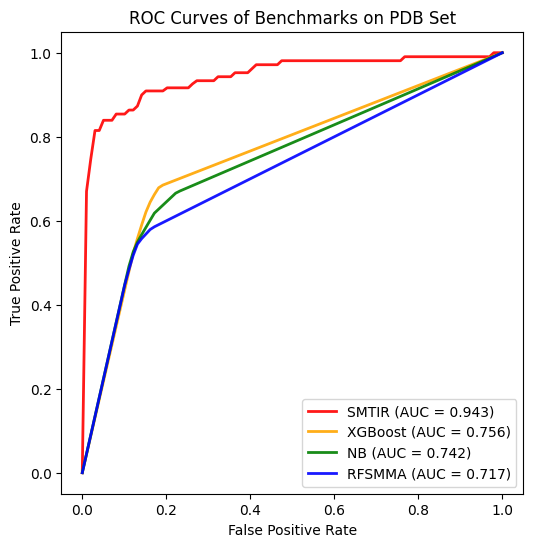

In [19]:
plot_roc(PDB_mean_tpr, "ROC Curves of Benchmarks on PDB Set")

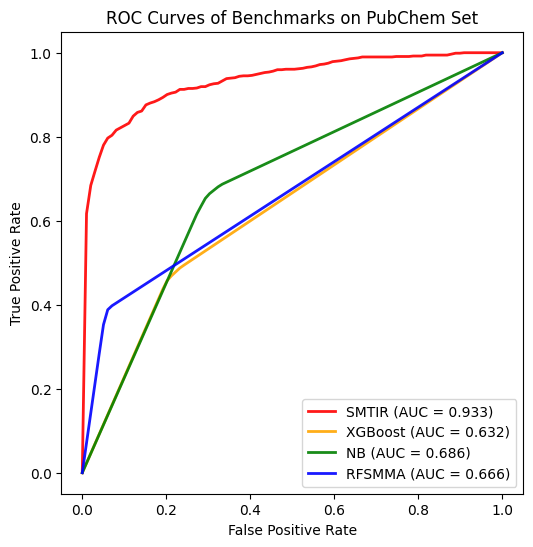

In [20]:
plot_roc(PubChem_mean_tpr, "ROC Curves of Benchmarks on PubChem Set")

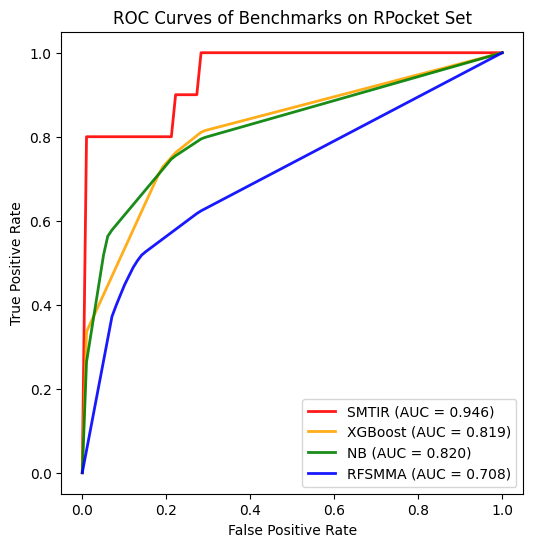

In [21]:
plot_roc(RPocket_mean_tpr, "ROC Curves of Benchmarks on RPocket Set")